In [ ]:
# Datasets, visit the links and download them.

# Football dataset: https://journals.sagepub.com/doi/10.1177/2515245917747646 -> https://osf.io/fv8c3
# Wine quality study dataset: https://github.com/rmcelreath/rethinking/blob/master/data/Wines2012.csv
# UCB admissions dataset: https://github.com/rmcelreath/rethinking/blob/master/data/UCBadmit_long.csv / https://discovery.cs.illinois.edu/dataset/berkeley/
# Trolley problem dataset: https://github.com/rmcelreath/rethinking/blob/master/data/Trolley.csv
# Traffic stop data: Nashville, Tennessee ("TN" -> "Nashville", it contains all data) https://openpolicing.stanford.edu/data/

# Data description for Rethinking dataset: https://github.com/rmcelreath/rethinking/tree/master/man

In [ ]:
!sudo pip install causalgraphicalmodels shap pymc pandas numpy statsmodels

In [247]:
# Hacky way of getting around Py3.10 issue (I had issues installing Py3.9 in Colab notebooks)
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
# Actual imports
from causalgraphicalmodels import CausalGraphicalModel
import pymc as pm
import pandas as pd
import numpy as np
import statsmodels.api as sm
from google.colab import files
import io
import shap
import xgboost
from sklearn.linear_model import LinearRegression

# Import your CSV file
uploaded = files.upload()

In [197]:
data_df = pd.read_csv(io.BytesIO(uploaded["CrowdstormingDataJuly1st.csv"]))
print(data_df.dtypes)
data_df.describe()

playerShort       object
player            object
club              object
leagueCountry     object
birthday          object
height           float64
weight           float64
position          object
games              int64
victories          int64
ties               int64
defeats            int64
goals              int64
yellowCards        int64
yellowReds         int64
redCards           int64
photoID           object
rater1           float64
rater2           float64
refNum             int64
refCountry         int64
Alpha_3           object
meanIAT          float64
nIAT             float64
seIAT            float64
meanExp          float64
nExp             float64
seExp            float64
dtype: object


,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
count,145765.000000,143785.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,124621.000000,124621.000000,146028.000000,146028.000000,145865.000000,1.458650e+05,1.458650e+05,145865.000000,1.458650e+05,145865.000000
mean,181.935938,76.075662,2.921166,1.278344,0.708241,0.934581,0.338058,0.385364,0.011381,0.012559,0.264255,0.302862,1534.827444,29.642842,0.346276,1.969741e+04,6.310849e-04,0.452026,2.044023e+04,0.002994
std,6.738726,7.140906,3.413633,1.790725,1.116793,1.383059,0.906481,0.795333,0.107931,0.112889,0.295382,0.293020,918.736625,27.496189,0.032246,1.271262e+05,4.735857e-03,0.217469,1.306157e+05,0.019723
min,161.000000,54.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-0.047254,2.000000e+00,2.235373e-07,-1.375000,2.000000e+00,0.000001
25%,177.000000,71.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,641.000000,7.000000,0.334684,1.785000e+03,5.454025e-05,0.336101,1.897000e+03,0.000225
50%,182.000000,76.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,1604.000000,21.000000,0.336628,2.882000e+03,1.508847e-04,0.356446,3.011000e+03,0.000586
75%,187.000000,81.000000,3.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.250000,0.500000,2345.000000,44.000000,0.369894,7.749000e+03,2.294896e-04,0.588297,7.974000e+03,0.001002
max,203.000000,100.000000,47.000000,29.000000,14.000000,18.000000,23.000000,14.000000,3.000000,2.000000,1.000000,1.000000,3147.000000,161.000000,0.573793,1.975803e+06,2.862871e-01,1.800000,2.029548e+06,1.060660


In [ ]:
# https://github.com/ijmbarr/causalgraphicalmodels/blob/master/notebooks/cgm-examples.ipynb
# https://github.com/ijmbarr/causalgraphicalmodels/blob/master/causalgraphicalmodels/examples.py

# First start with the relationship that you want to measure
dag_1 = CausalGraphicalModel(
    nodes=["ethnicity", "red_card"],
    edges=[
        # Quantity of interest
        ("ethnicity", "red_card")
    ]
)
dag_1.draw()


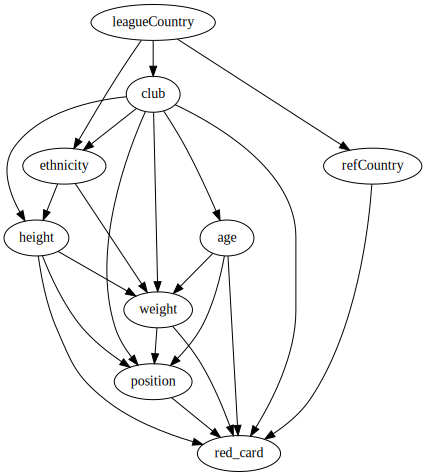

In [234]:
# Gradually add variables
nodes = ["ethnicity", "red_card", "height", "weight", "club", "leagueCountry",
         "position", "refCountry", "age"]
edges = [
    # Quantity of interest
    #("ethnicity", "red_card"),
    # Other associations
    ("ethnicity", "weight"),
    ("ethnicity", "height"),
    ("club", "ethnicity"),
    ("leagueCountry", "ethnicity"),
    ("height", "weight"),
    ("height", "position"),
    ("weight", "position"),
    ("leagueCountry", "club"),
    ("club", "age"),
    ("club", "height"),
    ("club", "weight"),
    ("club", "position"),
    ("age", "position"),
    ("age", "weight"),
    ("leagueCountry", "refCountry"),
    ("position", "n_games"),
    # Associations with the outcome
    ("height", "red_card"),
    ("weight", "red_card"),
    ("position", "red_card"),
    ("club", "red_card"),
    ("age", "red_card"),
    ("refCountry", "red_card")
]
# TODO: probably a good idea to validate this. This exercise is left to the reader.

dag_2 = CausalGraphicalModel(nodes=nodes, edges=edges)
dag_2.draw()

In [ ]:
# Independence relationships implied by your DAG
dag_2.get_all_independence_relationships()

In [245]:
# Gives me the variables that I need to condition on to only have the total effect (direct and indirect) of ethnicity on red_card
dag_2.get_all_backdoor_adjustment_sets(x="ethnicity", y="red_card")

frozenset({frozenset({'club', 'refCountry'}),
           frozenset({'club', 'leagueCountry', 'refCountry'}),
           frozenset({'age', 'club', 'refCountry'}),
           frozenset({'club', 'leagueCountry'}),
           frozenset({'age', 'club', 'leagueCountry'}),
           frozenset({'age', 'club', 'leagueCountry', 'refCountry'})})

In [246]:
# In this case, I want to only get the direct effect of ethnicity on red_card, so I need to block all the other paths
print([vars for vars in dag_2.get_all_independence_relationships() if (vars[0] == "red_card") and (vars[1] == "ethnicity")])

# d_separated means that there is no path from ethnicity to red_card (if we add it to the model, there's only the direct path)
print(dag_2.is_d_separated(x="ethnicity", y="red_card", zs={"club", "refCountry", "height", "weight", "age"}))
# Also take a look at https://www.dagitty.net/dags.html, it's perhaps more intuitive to look at direct and total effects

[('red_card', 'ethnicity', {'leagueCountry', 'height', 'club', 'age', 'weight'}), ('red_card', 'ethnicity', {'height', 'club', 'refCountry', 'age', 'weight'}), ('red_card', 'ethnicity', {'leagueCountry', 'height', 'position', 'club', 'weight', 'age'}), ('red_card', 'ethnicity', {'leagueCountry', 'height', 'club', 'refCountry', 'weight', 'age'}), ('red_card', 'ethnicity', {'height', 'position', 'club', 'refCountry', 'weight', 'age'}), ('red_card', 'ethnicity', {'leagueCountry', 'height', 'position', 'club', 'refCountry', 'weight', 'age'})]


In [ ]:
# Now what happens when you add variables that are missing?
dag_3 = CausalGraphicalModel(
    nodes=["ethnicity", "red_card"],
    edges=[
        # Quantity of interest
        ("ethnicity", "red_card")
        # you can also add them here
    ],
    latent_edges=[
        ("ethnicity", "red_card")  # There is some unknown variable between ethnicity and red_card
    ]
)



In [227]:
# Change the data so that it's appropriate for the model
model_data_df = ...

False

In [ ]:
# SHAP, using XGBoost & TreeExplainer
X = model_data_df[["weather", "ad_spend"]]
y = model_data_df["ice_cream_sales"]
model = xgboost.XGBRegressor()
model.fit(X, y)

# Create SHAP values (effect of each observation of each input on y)
explainer = shap.Explainer(model, X, algorithm="tree")
shap_values = explainer(X)

# Now create the SHAP plots, scatter is the most useful
shap.plots.scatter(shap_values)
# shap.summary_plot(shap_values, X)
# shap.plots.bar(shap_values)

In [ ]:
# Descriptive statistics (analytics)

# Come up with a simple rule/heuristic to try to estimate the effect (dividide something by something else)

In [ ]:
# Linear model (frequentist)
X = model_data_df[["", ""]]
X = sm.add_constant(X)
y = model_data_df[""]  # only 1 output

# Fitting the linear regression model
model = sm.OLS(y, X).fit()

model.summary()

In [ ]:
# Hierarchical model (Bayesian); NOTE: if you're a bit lost, ChatGPT is good at this ;)
# Define the Bayesian model
with pm.Model() as model:
    # Data
    weather = pm.Data("weather", model_data_df["weather"])
    ad_spend = pm.Data("ad_spend", model_data_df["ad_spend"])

    # Priors
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.25)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=0.25)
    sigma = pm.HalfNormal("σ", sigma=1)

    # Likelihood
    ice_cream_sales = pm.Normal("ice_cream_sales", mu=beta_1 * weather + beta_2 * ad_spend, sigma=sigma, observed=model_data_df["ice_cream_sales"])
    trace = pm.sample(1000, return_inferencedata=True)
#pm.plot_posterior(trace)  # posterior distribution of your parameters
#trace.posterior